In [1]:
import zipfile
with zipfile.ZipFile("EuroSAT.zip","r") as zip_ref:
    zip_ref.extractall()

In [1]:
import torch
import pandas as pd
import numpy as np
import sys, time

import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid


import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

SEED = 999
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True #to make reproducible result

cuda:0


In [3]:
DIR = '2750'

# 1. ETL

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [5]:
data = datasets.ImageFolder(DIR, transform=transform)
data

Dataset ImageFolder
    Number of datapoints: 27000
    Root location: 2750
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

# 2. EDA

In [6]:
classNames = list(data.class_to_idx)

In [7]:
def displayImage(img):
    img = img / 2 + 0.5 # denormalize image
    plt.imshow(transforms.ToPILImage()(img))

torch.Size([3, 64, 64])


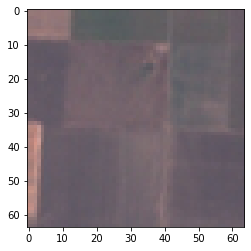

In [8]:
for temp in data:
    print(temp[0].shape)
    image = temp[0]
    displayImage(temp[0])
    break

In [9]:
def show_sample_images(dataset):
    loader = DataLoader(dataset, batch_size = 12, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch
    
    grid = make_grid(images, nrow = 6)
    grid = grid / 2 + 0.5 # denormalize image
    im_transpose = np.transpose(grid, (1, 2, 0)) 
    plt.figure(figsize=(11, 11))
    plt.imshow(im_transpose)
    print('Encoded Labels: ', labels)
    print('Labels:')
    for label in labels:
        print(classNames[label])

Encoded Labels:  tensor([7, 9, 8, 2, 1, 7, 9, 1, 0, 0, 3, 3])
Labels:
Residential
SeaLake
River
HerbaceousVegetation
Forest
Residential
SeaLake
Forest
AnnualCrop
AnnualCrop
Highway
Highway


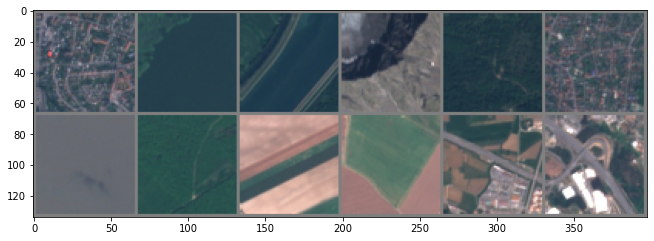

In [10]:
show_sample_images(data)

In [11]:
# getting labels/targets
classNames = list(data.class_to_idx)
classNames

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

## Checking if dataset is balanced

In [12]:
# counting no. of each label
labels, noOfImagesPerClass = torch.unique(torch.tensor(data.targets), return_counts=True)

In [13]:
classCount =  pd.DataFrame({'class': labels, 'count': noOfImagesPerClass})

In [14]:
classCount

class  count
0      0   3000
1      1   3000
2      2   3000
3      3   2500
4      4   2500
5      5   2000
6      6   2500
7      7   3000
8      8   2500
9      9   3000

In [15]:
for index, i in enumerate(range(len(noOfImagesPerClass))):
    print(f"{index} {classNames[i]}: {noOfImagesPerClass[i]}")

0 AnnualCrop: 3000
1 Forest: 3000
2 HerbaceousVegetation: 3000
3 Highway: 2500
4 Industrial: 2500
5 Pasture: 2000
6 PermanentCrop: 2500
7 Residential: 3000
8 River: 2500
9 SeaLake: 3000


<AxesSubplot:xlabel='class', ylabel='count'>

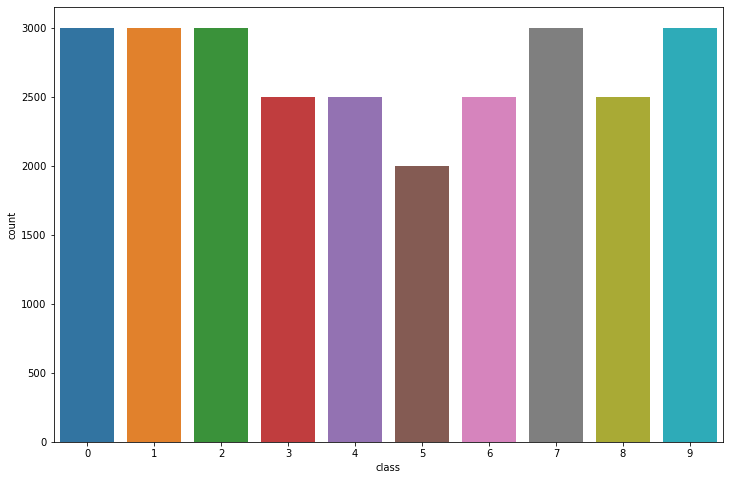

In [16]:
plt.figure(figsize=(12, 8))
sns.barplot(x = 'class', y='count', data = classCount)

In [17]:
len(data)

27000

In [18]:
train_set, test_set = torch.utils.data.random_split(data, [21600, 5400])  # test set 20 percent
train_set, val_set = torch.utils.data.random_split(train_set, [16200, 5400]) # valid set 20 percent

In [19]:
batch_size = 50

train_loader = DataLoader(train_set, batch_size, shuffle=True, num_workers=2, pin_memory=True)
# val_loader = DataLoader(val_set, len(val_set), shuffle=True)
# test_loader = DataLoader(test_set, len(test_set), shuffle=True)
val_loader = DataLoader(val_set, batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, batch_size, shuffle=True, num_workers=2, pin_memory=True)

# 3. Create Model

## Model 1: Base CNN Model

In [20]:
class EuroCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv = nn.Conv2d(3, 50, 3, 1)
        self.maxpool = nn.MaxPool2d(2, 2)
        
        self.linear = nn.Linear(50*31*31, 10)
        self.relu    = nn.ReLU()
        self.dropoutLayer = nn.Dropout(p=0.2)
        # self.relu    = nn.ReLU()
    
    def forward(self, image):
        out = self.conv(image) 
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = out.reshape(-1, 50*31*31)
        out = self.linear(out)
        out = self.dropoutLayer(out)
        return out

## Model 2: Deeper CNN Model

In [21]:
class deepEuroCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 100, 3, 1, 0)
        #self.batchNorm1 = nn.BatchNorm2d(num_features=100)
        self.maxpool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(100, 200, 3, 1, 0)
        #self.batchNorm2 = nn.BatchNorm2d(num_features=200)
        
        self.linear1 = nn.Linear(200*14*14, 50)
        self.linear2 = nn.Linear(50, 30)
        self.linear3 = nn.Linear(30, 10)
        self.relu    = nn.ReLU()
        self.dropoutLayer = nn.Dropout(p=0.2)
    
    def forward(self, image):
        out = self.conv1(image) 
        out = self.relu(out)
        #out = self.batchNorm1(out)
        out = self.maxpool(out)
        
        out = self.conv2(out) 
        out = self.relu(out)
        #out = self.batchNorm2(out)
        out = self.maxpool(out)
        
        out = out.reshape(-1, 200*14*14)
        out = self.linear1(out)
        out = self.relu(out)
        # out = self.dropoutLayer(out)
        
        out = self.linear2(out)
        out = self.relu(out)
        # out = self.dropoutLayer(out)
        
        out = self.linear3(out)
        out = self.dropoutLayer(out)
        return out

In [22]:
## Model 3: More Deeper CNN Model

In [23]:
class deeperEuroCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 64, 3, 1, 0)
        #self.batchNorm1 = nn.BatchNorm2d(num_features=64)
        self.maxpool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(64, 128, 3, 1, 0)
        #self.batchNorm2 = nn.BatchNorm2d(num_features=128)
        
        self.conv3 = nn.Conv2d(128, 256, 3, 1, 0)
        #self.batchNorm3 = nn.BatchNorm2d(num_features=256)
        
        
        self.linear1 = nn.Linear(256*6*6, 200)
        self.linear2 = nn.Linear(200, 100)
        self.linear3 = nn.Linear(100, 75)
        self.linear4 = nn.Linear(75, 10)
        self.relu    = nn.ReLU()
        self.dropoutLayer = nn.Dropout(p=0.3)
    
    def forward(self, image):
        out = self.conv1(image) 
        out = self.relu(out)
        #out = self.batchNorm1(out)
        out = self.maxpool(out)
        
        out = self.conv2(out) 
        out = self.relu(out)
        #out = self.batchNorm2(out)
        out = self.maxpool(out)
        
        out = self.conv3(out) 
        out = self.relu(out)
        #out = self.batchNorm3(out)
        out = self.maxpool(out)
        
        out = out.reshape(-1, 256*6*6)
        #out = self.dropoutLayer(out)
        
        out = self.linear1(out)
        out = self.relu(out)
        #out = self.dropoutLayer(out)
        
        out = self.linear2(out)
        out = self.relu(out)
        #out = self.dropoutLayer(out)
        
        out = self.linear3(out)
        out = self.relu(out)
        #out = self.dropoutLayer(out)
        
        out = self.linear4(out)
        out = self.dropoutLayer(out)
        return out

# 4. Train Model

## Train Model 1

In [24]:
baseModel = EuroCNN().to(device)

In [25]:
print(baseModel)

EuroCNN(
  (conv): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear): Linear(in_features=48050, out_features=10, bias=True)
  (relu): ReLU()
  (dropoutLayer): Dropout(p=0.2, inplace=False)
)


## Model Parameters

In [26]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [27]:
count_parameters(baseModel)

  1350
    50
480500
    10
______
481910


## Test Model

In [28]:
random_image = torch.rand((50, 3, 64, 64)).to(device)
out = baseModel(random_image)
print(out.shape)

torch.Size([50, 10])


## Loss function and optimizer

In [29]:
J_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(baseModel.parameters(), lr=0.001)

## Train Model

In [30]:
class EarlyStopping():
    def __init__(self, patience, threshold):
        self.patience      = 5
        self.threshold     = 0.1
        self.prev_val_loss = None
        self.patienceCount = 0
        
    def _checkPatience(self,):
        if self.patienceCount == self.patience:
            return True
        else:
            self.patienceCount += 1
            return False
    
    def checkCondition(self, val_loss):
        if self.prev_val_loss == None:
            self.prev_val_loss = val_loss
        elif val_loss - self.prev_val_loss > self.threshold:
            return self._checkPatience()
        
        self.patienceCount = 0
        return False

In [32]:
def train(model, optimizer, J_fn, filepath, epochs=20, patience = 5, threshold = 0.1):
    
    earlyStopping = EarlyStopping(patience, threshold)
    
    val_old_loss = float("Inf")
    train_losses = []
    train_accs   = []
    avg_train_losses_per_epoch = []
    avg_train_accs_per_epoch   = []
    val_losses   = []
    val_accs     = []
    training_time = []
    training_time_per_epoch = []
    
    for e in range(epochs):
        total_corr       = 0
        total_loss       = 0
        total_train_loss = 0
        total_time_epoch = 0
        for b, (image, label) in enumerate(train_loader):
            start_time = time.time()

            image = image.to(device)
            label = label.to(device)

            yhat = model(image)
            train_loss = J_fn(yhat, label)
            total_train_loss += train_loss

            train_losses.append(train_loss)
            predicted = torch.max(yhat, 1)[1]
            batch_corr = (predicted == label).sum()
            total_corr += batch_corr

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            train_acc = (total_corr * 100) / (batch_size * (b + 1))
            train_accs.append(train_acc)

            total_time = time.time() - start_time
            total_time_epoch += total_time
            training_time.append(total_time)

            if (b+1) % 50 == 0:
                print(f"Epoch: {e + 1} - Batch: {b + 1} - Train Loss: {train_loss:.2f} - Train Acc: {train_acc:.2f} - Total Time: {total_time:.2f}s")
                # print("Loss Gradient for first Conv Layer: ", torch.mean(model.conv1.weight.grad) )
        
        avg_train_time = total_time_epoch / len(train_loader)
        training_time_per_epoch.append(avg_train_time)
        
        avg_train_loss = total_train_loss / len(train_loader)   
        avg_train_acc  = (total_corr * 100) / len(train_set)
        
        avg_train_losses_per_epoch.append(avg_train_loss)
        avg_train_accs_per_epoch.append(avg_train_acc)
        
        print(f"++++++End of Epoch {e + 1} ++++++ Avg Train Loss: {avg_train_loss:.2f} - Avg Train Acc: {avg_train_acc:.2f} - Avg Train Time: {avg_train_time:.2f}")

        with torch.no_grad():
            val_corr       = 0 
            total_val_loss = 0
            for val_image, val_label in val_loader:
                val_image = val_image.to(device)
                val_label = val_label.to(device)
                val_yhat = model(val_image)
                val_loss = J_fn(val_yhat, val_label)
                total_val_loss += val_loss
                val_predicted = torch.max(val_yhat, 1)[1]
                val_corr += (val_predicted == val_label).sum()
            val_acc = (val_corr * 100) / len(val_set)
            avg_val_loss = total_val_loss / len(val_loader)
            val_accs.append(val_acc)
            val_losses.append(val_loss)
            
            if avg_val_loss < val_old_loss:
                val_old_loss = avg_val_loss
                saveObject = {
                    'epoch': e + 1,
                    'batch': b + 1,
                    'train_loss': avg_train_loss,
                    'train_acc': avg_train_acc,
                    'val_loss': avg_val_loss,
                    'val_acc': val_acc,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                }
                torch.save(saveObject, filepath)
            
        if earlyStopping.checkCondition(avg_val_loss):
            break
            
        print(f"++++++Validation++++++ Val Loss: {avg_val_loss:.2f} - Val Acc: {val_acc:.2f}")
        
        
    return train_losses, avg_train_losses_per_epoch, train_accs, avg_train_accs_per_epoch, training_time, training_time_per_epoch, val_losses, val_accs

In [33]:
filepath = 'bestmodel1.pt'

In [34]:
train_losses, avg_train_losses_per_epoch, train_accs, avg_train_accs_per_epoch, training_time, training_time_per_epoch, val_losses, val_accs = train(baseModel, optimizer, J_fn, filepath)

Epoch: 1 - Batch: 50 - Train Loss: 1.47 - Train Acc: 32.32 - Total Time: 0.00s
Epoch: 1 - Batch: 100 - Train Loss: 1.67 - Train Acc: 42.74 - Total Time: 0.00s
Epoch: 1 - Batch: 150 - Train Loss: 1.48 - Train Acc: 45.71 - Total Time: 0.00s
Epoch: 1 - Batch: 200 - Train Loss: 1.05 - Train Acc: 48.12 - Total Time: 0.00s
Epoch: 1 - Batch: 250 - Train Loss: 1.22 - Train Acc: 49.38 - Total Time: 0.00s
Epoch: 1 - Batch: 300 - Train Loss: 1.37 - Train Acc: 50.96 - Total Time: 0.00s
++++++End of Epoch 1 ++++++ Avg Train Loss: 1.45 - Avg Train Acc: 51.27 - Avg Train Time: 0.00
++++++Validation++++++ Val Loss: 1.26 - Val Acc: 55.24
Epoch: 2 - Batch: 50 - Train Loss: 1.20 - Train Acc: 62.16 - Total Time: 0.00s
Epoch: 2 - Batch: 100 - Train Loss: 1.16 - Train Acc: 62.58 - Total Time: 0.00s
Epoch: 2 - Batch: 150 - Train Loss: 1.24 - Train Acc: 63.24 - Total Time: 0.00s
Epoch: 2 - Batch: 200 - Train Loss: 1.13 - Train Acc: 62.72 - Total Time: 0.00s
Epoch: 2 - Batch: 250 - Train Loss: 1.13 - Train Acc

## Plotting loss

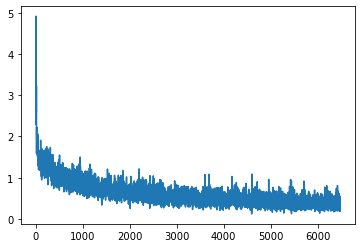

In [35]:
plt.plot(torch.Tensor(train_losses).cpu())

In [36]:
def plotLoss(trainingLoss, valLoss):
    plt.plot(trainingLoss)
    plt.plot(valLoss)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Training Loss", "Val Loss"])

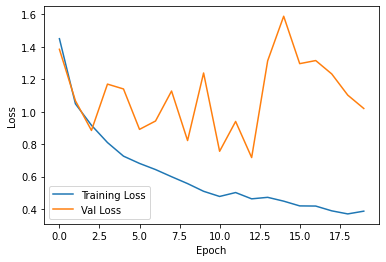

In [37]:
plotLoss(torch.Tensor(avg_train_losses_per_epoch).cpu(), torch.Tensor(val_losses).cpu())

## Plotting accuracy

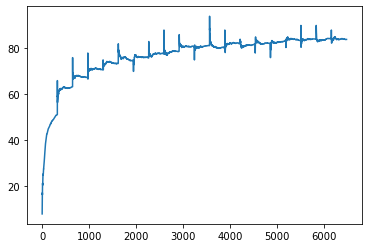

In [38]:
plt.plot(torch.Tensor(train_accs).cpu())

In [39]:
def plotAccuracy(trainingAcc, valAcc):
    plt.plot(trainingAcc)
    plt.plot(valAcc)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend(["Training Accuracy", "Val Accuracy"])

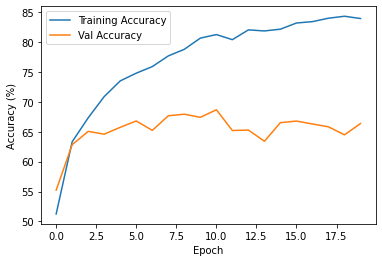

In [40]:
plotAccuracy(torch.Tensor(avg_train_accs_per_epoch).cpu(), torch.Tensor(val_accs).cpu())

## Plotting training time

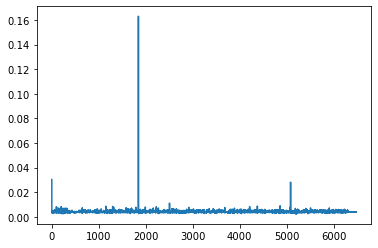

In [41]:
plt.plot(torch.Tensor(training_time).cpu())

In [42]:
def plotTrainingTime(training_time):
    plt.plot(training_time)
    plt.xlabel("Epoch")
    plt.ylabel("Training Time (s)")

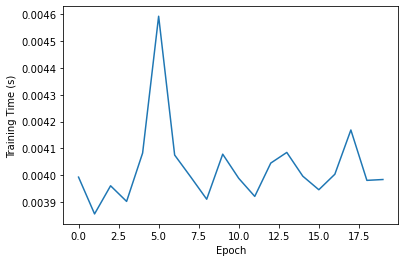

In [43]:
plotTrainingTime(training_time_per_epoch)

In [44]:
saveObject = {
    'train_losses': train_losses,
    'avg_train_losses_per_epoch': avg_train_losses_per_epoch,
    'train_accs': train_accs,
    'avg_train_accs_per_epoch': avg_train_accs_per_epoch,
    'training_time': training_time,
    'training_time_per_epoch': training_time_per_epoch,
    'val_losses': val_losses,
    'val_accs': val_accs
}

torch.save(saveObject, 'baseModeltrainingHist.pt')

## Plot from saved file

In [45]:
loadObject1 = torch.load('baseModeltrainingHist.pt')

## Potting loss

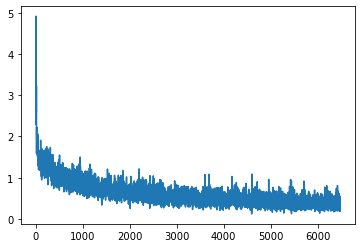

In [46]:
plt.plot(torch.Tensor(loadObject1['train_losses']).cpu())

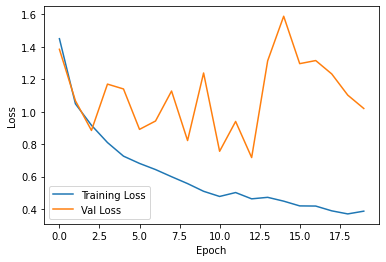

In [47]:
plotLoss(torch.Tensor(loadObject1['avg_train_losses_per_epoch']).cpu(), torch.Tensor(loadObject1['val_losses']).cpu())

## Plotting accuracy

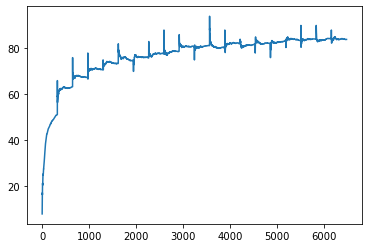

In [48]:
plt.plot(torch.Tensor(loadObject1['train_accs']).cpu())

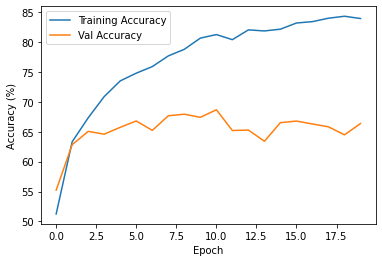

In [49]:
plotAccuracy(torch.Tensor(loadObject1['avg_train_accs_per_epoch']).cpu(), torch.Tensor(loadObject1['val_accs']).cpu())

## Plotting training time

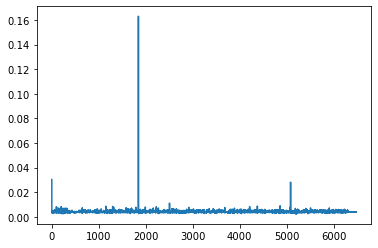

In [50]:
plt.plot(torch.Tensor(loadObject1['training_time']).cpu())

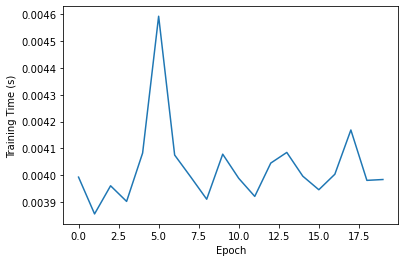

In [51]:
plotTrainingTime(loadObject1['training_time_per_epoch'])

# Train Model 2

In [52]:
model2 = deepEuroCNN().to(device)

In [53]:
print(model2)

deepEuroCNN(
  (conv1): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(100, 200, kernel_size=(3, 3), stride=(1, 1))
  (linear1): Linear(in_features=39200, out_features=50, bias=True)
  (linear2): Linear(in_features=50, out_features=30, bias=True)
  (linear3): Linear(in_features=30, out_features=10, bias=True)
  (relu): ReLU()
  (dropoutLayer): Dropout(p=0.2, inplace=False)
)


## Model Parameters

In [54]:
count_parameters(model2)

  2700
   100
180000
   200
1960000
    50
  1500
    30
   300
    10
______
2144890


## Test Model

In [55]:
random_image = torch.rand((50, 3, 64, 64)).to(device)
out = model2(random_image)
print(out.shape)

torch.Size([50, 10])


## Loss function and optimizer

In [56]:
J_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

## Train Model

In [57]:
filepath2 = 'bestModel2.pt'

In [58]:
train_losses2, avg_train_losses_per_epoch2, train_accs2, avg_train_accs_per_epoch2, training_time2, training_time_per_epoch2, val_losses2, val_accs2 = train(model2, optimizer, J_fn, filepath2)

Epoch: 1 - Batch: 50 - Train Loss: 1.63 - Train Acc: 26.32 - Total Time: 0.01s
Epoch: 1 - Batch: 100 - Train Loss: 1.43 - Train Acc: 35.06 - Total Time: 0.01s
Epoch: 1 - Batch: 150 - Train Loss: 1.49 - Train Acc: 40.32 - Total Time: 0.01s
Epoch: 1 - Batch: 200 - Train Loss: 1.12 - Train Acc: 43.55 - Total Time: 0.01s
Epoch: 1 - Batch: 250 - Train Loss: 1.32 - Train Acc: 46.28 - Total Time: 0.01s
Epoch: 1 - Batch: 300 - Train Loss: 0.91 - Train Acc: 48.67 - Total Time: 0.01s
++++++End of Epoch 1 ++++++ Avg Train Loss: 1.37 - Avg Train Acc: 49.60 - Avg Train Time: 0.01
++++++Validation++++++ Val Loss: 1.07 - Val Acc: 62.20
Epoch: 2 - Batch: 50 - Train Loss: 0.93 - Train Acc: 62.44 - Total Time: 0.01s
Epoch: 2 - Batch: 100 - Train Loss: 0.81 - Train Acc: 63.18 - Total Time: 0.01s
Epoch: 2 - Batch: 150 - Train Loss: 0.93 - Train Acc: 63.44 - Total Time: 0.01s
Epoch: 2 - Batch: 200 - Train Loss: 0.96 - Train Acc: 64.20 - Total Time: 0.01s
Epoch: 2 - Batch: 250 - Train Loss: 0.79 - Train Acc

## Plotting loss

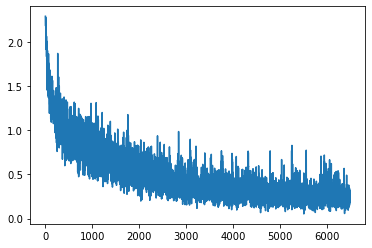

In [59]:
plt.plot(torch.Tensor(train_losses2).cpu())

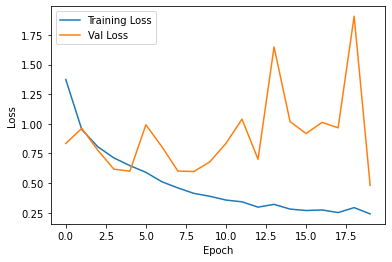

In [60]:
plotLoss(torch.Tensor(avg_train_losses_per_epoch2).cpu(), torch.Tensor(val_losses2).cpu())

## Plotting accuracy

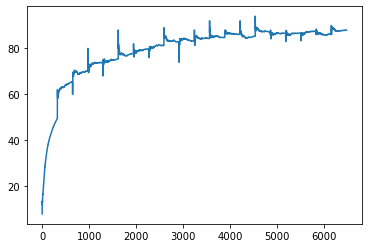

In [61]:
plt.plot(torch.Tensor(train_accs2).cpu())

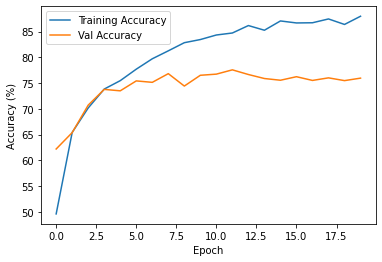

In [62]:
plotAccuracy(torch.Tensor(avg_train_accs_per_epoch2).cpu(), torch.Tensor(val_accs2).cpu())

## Plotting training time

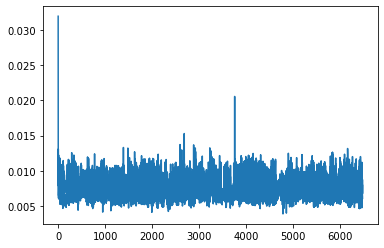

In [63]:
plt.plot(torch.Tensor(training_time2).cpu())

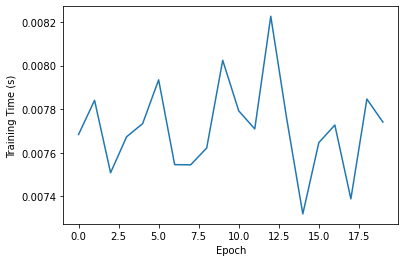

In [64]:
plotTrainingTime(training_time_per_epoch2)

In [65]:
saveObject = {
    'train_losses': train_losses2,
    'avg_train_losses_per_epoch': avg_train_losses_per_epoch2,
    'train_accs': train_accs2,
    'avg_train_accs_per_epoch': avg_train_accs_per_epoch2,
    'training_time': training_time2,
    'training_time_per_epoch': training_time_per_epoch2,
    'val_losses': val_losses2,
    'val_accs': val_accs2
}

torch.save(saveObject, 'Model2TrainingHist')

# Train Model 3

In [66]:
model3 = deeperEuroCNN().to(device)

In [67]:
print(model3)

deeperEuroCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (linear1): Linear(in_features=9216, out_features=200, bias=True)
  (linear2): Linear(in_features=200, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=75, bias=True)
  (linear4): Linear(in_features=75, out_features=10, bias=True)
  (relu): ReLU()
  (dropoutLayer): Dropout(p=0.3, inplace=False)
)


## Model Parameters

In [68]:
count_parameters(model3)

  1728
    64
 73728
   128
294912
   256
1843200
   200
 20000
   100
  7500
    75
   750
    10
______
2242651


## Test Model

In [69]:
random_image = torch.rand((50, 3, 64, 64)).to(device)
out = model3(random_image)
print(out.shape)

torch.Size([50, 10])


## Loss function and optimizer

In [70]:
J_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=0.001)

## Train Model

In [71]:
filepath3 = 'bestModel3Para.pt'

In [72]:
train_losses3, avg_train_losses_per_epoch3, train_accs3, avg_train_accs_per_epoch3, training_time3, training_time_per_epoch3, val_losses3, val_accs3 = train(model3, optimizer, J_fn, filepath3)

Epoch: 1 - Batch: 50 - Train Loss: 1.93 - Train Acc: 21.08 - Total Time: 0.01s
Epoch: 1 - Batch: 100 - Train Loss: 1.54 - Train Acc: 26.40 - Total Time: 0.01s
Epoch: 1 - Batch: 150 - Train Loss: 1.64 - Train Acc: 30.71 - Total Time: 0.01s
Epoch: 1 - Batch: 200 - Train Loss: 1.42 - Train Acc: 33.22 - Total Time: 0.01s
Epoch: 1 - Batch: 250 - Train Loss: 1.38 - Train Acc: 35.30 - Total Time: 0.01s
Epoch: 1 - Batch: 300 - Train Loss: 1.37 - Train Acc: 37.01 - Total Time: 0.01s
++++++End of Epoch 1 ++++++ Avg Train Loss: 1.65 - Avg Train Acc: 37.65 - Avg Train Time: 0.01
++++++Validation++++++ Val Loss: 1.32 - Val Acc: 52.04
Epoch: 2 - Batch: 50 - Train Loss: 1.24 - Train Acc: 49.36 - Total Time: 0.01s
Epoch: 2 - Batch: 100 - Train Loss: 1.22 - Train Acc: 49.50 - Total Time: 0.01s
Epoch: 2 - Batch: 150 - Train Loss: 1.48 - Train Acc: 50.01 - Total Time: 0.01s
Epoch: 2 - Batch: 200 - Train Loss: 1.07 - Train Acc: 50.76 - Total Time: 0.01s
Epoch: 2 - Batch: 250 - Train Loss: 1.09 - Train Acc

## Plotting loss

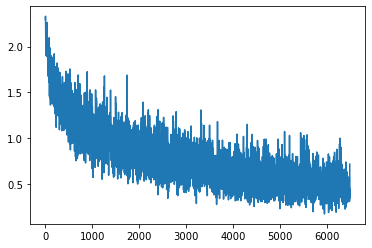

In [73]:
plt.plot(torch.Tensor(train_losses3).cpu())

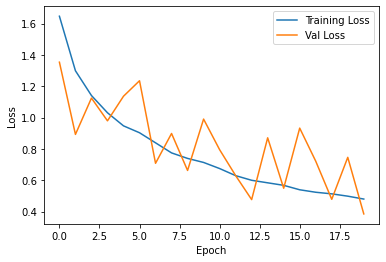

In [74]:
plotLoss(torch.Tensor(avg_train_losses_per_epoch3).cpu(), torch.Tensor(val_losses3).cpu())

## Plotting accuracy

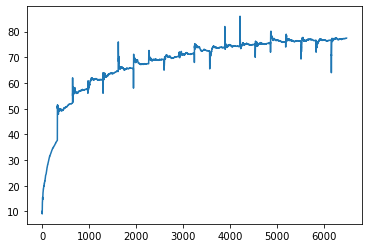

In [75]:
plt.plot(torch.Tensor(train_accs3).cpu())

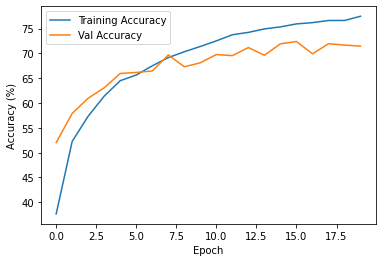

In [76]:
plotAccuracy(torch.Tensor(avg_train_accs_per_epoch3).cpu(), torch.Tensor(val_accs3).cpu())

## Plotting training time

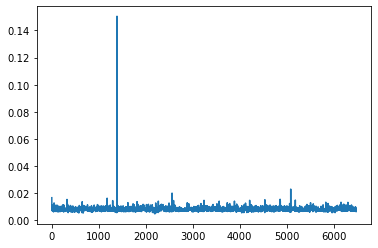

In [77]:
plt.plot(torch.Tensor(training_time3).cpu())

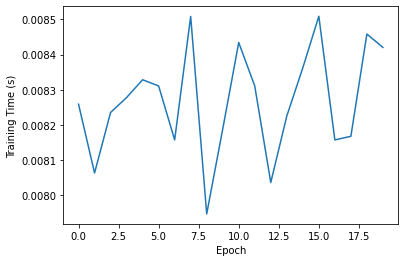

In [78]:
plotTrainingTime(training_time_per_epoch3)

In [79]:
saveObject = {
    'train_losses': train_losses3,
    'avg_train_losses_per_epoch': avg_train_losses_per_epoch3,
    'train_accs': train_accs3,
    'avg_train_accs_per_epoch': avg_train_accs_per_epoch3,
    'training_time': training_time3,
    'training_time_per_epoch': training_time_per_epoch3,
    'val_losses': val_losses3,
    'val_accs': val_accs3
}

torch.save(saveObject, 'Model3TrainingHist')

## Comparison of Three Models

## Training Loss plot

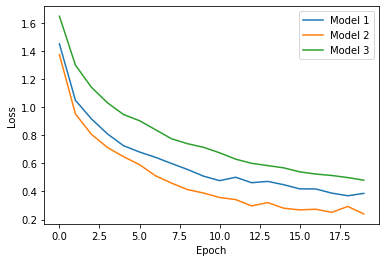

In [80]:
plt.plot(torch.Tensor(avg_train_losses_per_epoch).cpu())
plt.plot(torch.Tensor(avg_train_losses_per_epoch2).cpu())
plt.plot(torch.Tensor(avg_train_losses_per_epoch3).cpu())
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Model 1", "Model 2", "Model 3"])

## Validation Loss Plot

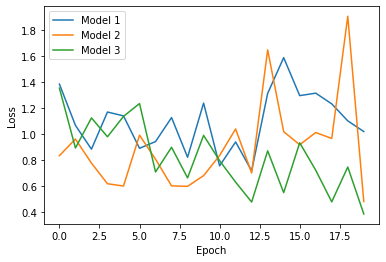

In [81]:
plt.plot(torch.Tensor(val_losses).cpu())
plt.plot(torch.Tensor(val_losses2).cpu())
plt.plot(torch.Tensor(val_losses3).cpu())
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Model 1", "Model 2", "Model 3"])

## Accuracy Plot (Training data)

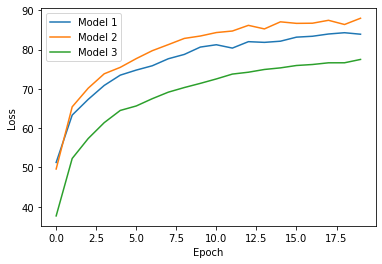

In [82]:
plt.plot(torch.Tensor(avg_train_accs_per_epoch).cpu())
plt.plot(torch.Tensor(avg_train_accs_per_epoch2).cpu())
plt.plot(torch.Tensor(avg_train_accs_per_epoch3).cpu())
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Model 1", "Model 2", "Model 3"])

## Accuracy Plot (Validation data)

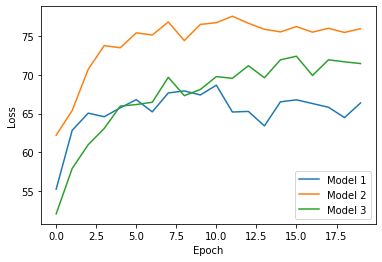

In [83]:
plt.plot(torch.Tensor(val_accs).cpu())
plt.plot(torch.Tensor(val_accs2).cpu())
plt.plot(torch.Tensor(val_accs3).cpu())
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Model 1", "Model 2", "Model 3"])

# 5. Test

In [84]:
checkpoint1 = torch.load(filepath)
checkpoint2 = torch.load(filepath2)
checkpoint3 = torch.load(filepath3)

In [85]:
bestModel1 = EuroCNN().to(device)
bestModel2 = deepEuroCNN().to(device)
bestModel3 = deeperEuroCNN().to(device)

In [86]:
bestModel1.load_state_dict(checkpoint1['model_state_dict'])
bestModel2.load_state_dict(checkpoint2['model_state_dict'])
bestModel3.load_state_dict(checkpoint3['model_state_dict'])

<All keys matched successfully>

In [87]:
bestModel1.eval()
bestModel2.eval()
bestModel3.eval()

deeperEuroCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (linear1): Linear(in_features=9216, out_features=200, bias=True)
  (linear2): Linear(in_features=200, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=75, bias=True)
  (linear4): Linear(in_features=75, out_features=10, bias=True)
  (relu): ReLU()
  (dropoutLayer): Dropout(p=0.3, inplace=False)
)

In [88]:
def testModel(model):
    with torch.no_grad():
        correct = 0
        acc     = 0
        total   = 0
        allPrediction       = []
        correctLabels       = []
        misclassifiedLabels = []
        
        for images, targets in test_loader:
            images  = images.to(device)
            targets = targets.to(device)                  

            yhat    = model(images)
            predicted = torch.max(yhat, 1)[1] 
            batch_corr = (predicted == targets).sum()
            correct   += batch_corr
            total     += targets.shape[0]
            
            for i in range(len(predicted)):
                if predicted[i] != targets[i]:
                    misclassifiedLabels.append({
                        'correctLabel': targets[i],
                        'predicted': predicted[i],
                        'image': images[i]
                    })

            allPrediction.append(predicted)
            correctLabels.append(targets)

        acc = 100 * correct / total
        print(f"Accuracy: {acc:.2f}")
        
        return allPrediction, correctLabels, misclassifiedLabels

## Accuracy of Model 1

In [89]:
allPrediction1, correctLabels1, misclassifiedLabels1 = testModel(bestModel1)

Accuracy: 78.57


## Accuracy of Model 2

In [90]:
allPrediction2, correctLabels2, misclassifiedLabels2 = testModel(bestModel2)

Accuracy: 85.56


## Accuracy of Model 3

In [91]:
allPrediction3, correctLabels3, misclassifiedLabels3 = testModel(bestModel3)

Accuracy: 88.26


## Display Confusion Matrix

In [92]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Model 1

In [93]:
allPredictionTensor1 = allPrediction1[0]
correctLabelsTensor1 = correctLabels1[0]

In [94]:
for i in range(1, len(allPrediction1)):
    allPredictionTensor1 = torch.cat((allPredictionTensor1, allPrediction1[i]))
    
for i in range(1, len(correctLabels1)):
    correctLabelsTensor1 = torch.cat((correctLabelsTensor1, correctLabels1[i]))

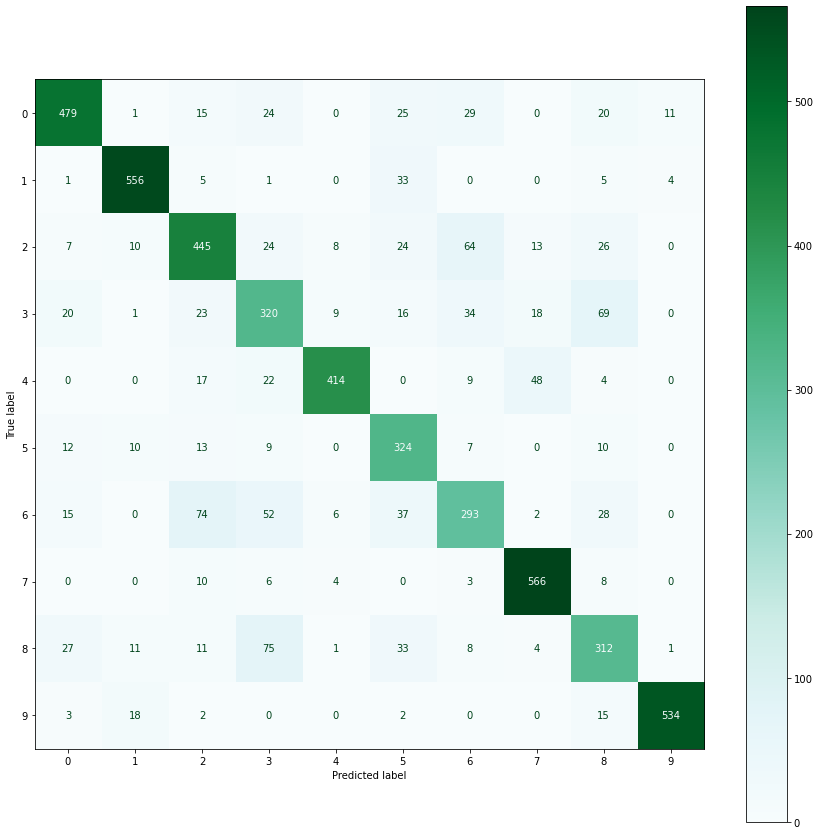

In [95]:
confusion_matrix_report1 = confusion_matrix(correctLabelsTensor1.cpu(), allPredictionTensor1.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix_report1)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax, cmap='BuGn')

## Model 2

In [96]:
allPredictionTensor2 = allPrediction2[0]
correctLabelsTensor2 = correctLabels2[0]

In [97]:
for i in range(1, len(allPrediction2)):
    allPredictionTensor2 = torch.cat((allPredictionTensor2, allPrediction2[i]))
    
for i in range(1, len(correctLabels2)):
    correctLabelsTensor2 = torch.cat((correctLabelsTensor2, correctLabels2[i]))

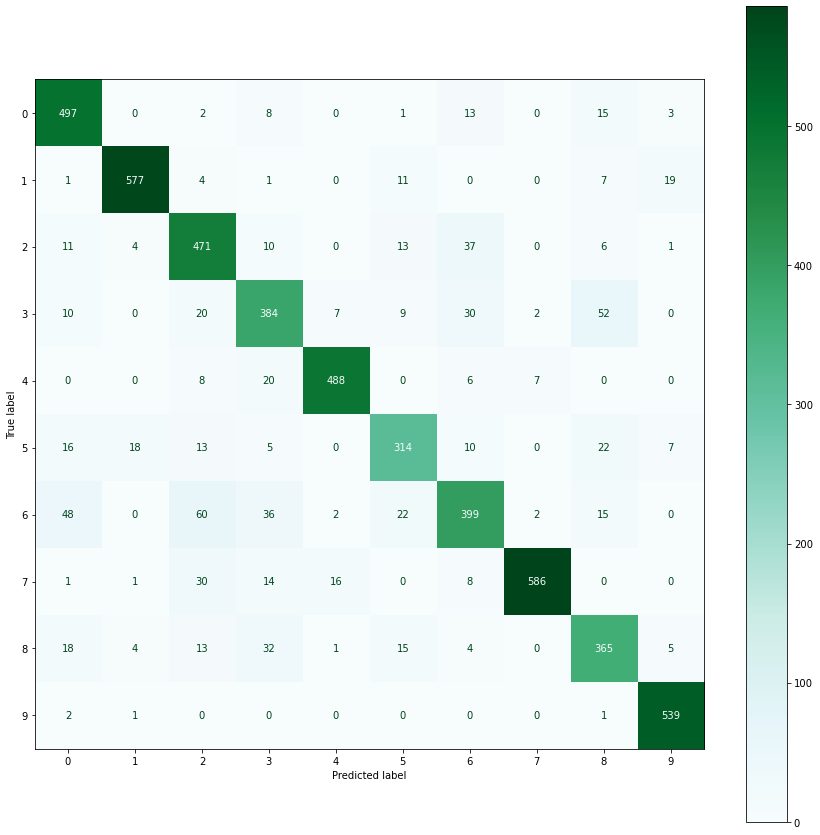

In [98]:
confusion_matrix_report2 = confusion_matrix(allPredictionTensor2.cpu(), correctLabelsTensor2.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix_report2)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax, cmap='BuGn')

## Model 3

In [99]:
allPredictionTensor3 = allPrediction3[0]
correctLabelsTensor3 = correctLabels3[0]

In [100]:
for i in range(1, len(allPrediction3)):
    allPredictionTensor3 = torch.cat((allPredictionTensor3, allPrediction3[i]))
    
for i in range(1, len(correctLabels3)):
    correctLabelsTensor3 = torch.cat((correctLabelsTensor3, correctLabels3[i]))

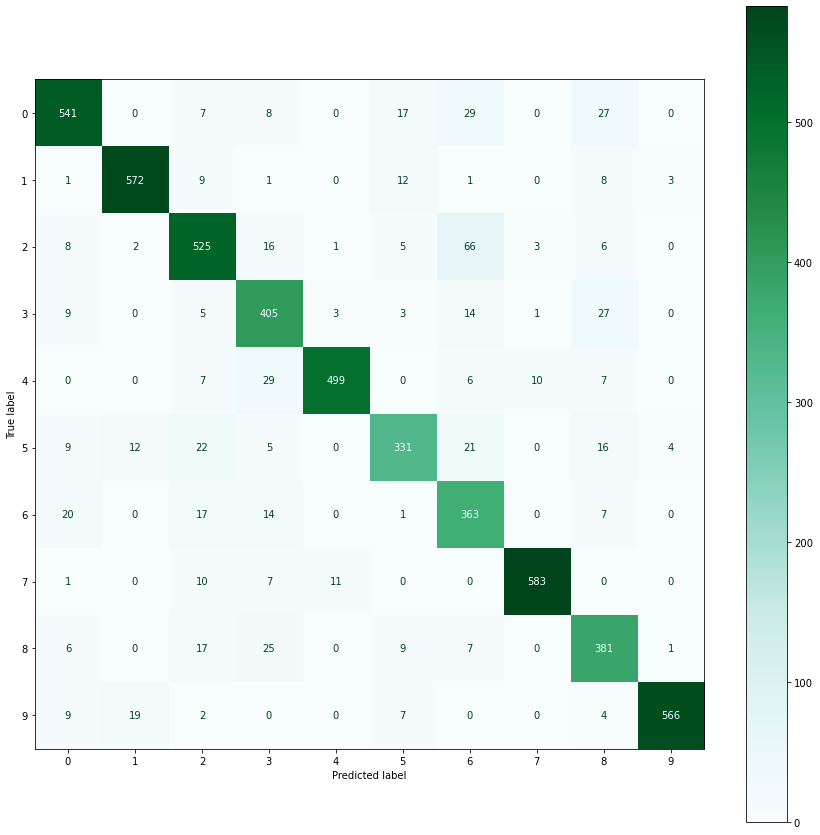

In [101]:
confusion_matrix_report3 = confusion_matrix(allPredictionTensor3.cpu(), correctLabelsTensor3.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix_report3)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax, cmap='BuGn')

## Examined Misclassified Images

In [102]:
def count_misclassified_images_per_label(confusion_matrix_report):
    total_number_misclassified_labels = []
    misclassified_labels_percentage   = []
    for i in range(len(confusion_matrix_report)):
        total_label_misclassified = sum(confusion_matrix_report[i][:i]) + sum(confusion_matrix_report[i][i + 1:])
        total_number_misclassified_labels.append(total_label_misclassified)
        
        total_no_of_label            = sum(confusion_matrix_report[i])
        label_classfication_accuracy = 100 * confusion_matrix_report[i][i] / total_no_of_label
        misclassified_labels_percentage.append(label_classfication_accuracy)
    return total_number_misclassified_labels, misclassified_labels_percentage

In [103]:
def top_misclassified_predicted_labels(confusion_matrix_report, labels):
    top_three_misclassifications_per_label = {}
    for label in labels:
        sorted_indices       = np.argsort(confusion_matrix_report[label])
        top_three_mislabeled = np.argsort(confusion_matrix_report[label])[-4:-1]
        
        top_three_misclassifications_per_label[label] = top_three_mislabeled
    
    return top_three_misclassifications_per_label

In [104]:
def plot_misclassified_images_per_labels(misclassified_images_per_labels, label_prediction_accuracy, title1, title2, labels):
    plt.figure(figsize=(12,6))
    plt.bar(labels, misclassified_images_per_labels)
    plt.xlabel("Labels")
    plt.ylabel("No of Missclassifications")
    plt.title(title1)
    plt.show()
    
    plt.figure(figsize=(12,6))
    plt.bar(labels, label_prediction_accuracy)
    plt.xlabel("Labels")
    plt.ylabel("Prediction Accuracy")
    plt.title(title2)
    plt.show()

In [105]:
def show_misclassified_images_per_labels(label, top_3_mislabeled, misclassifiedLabels):
    if label not in top_3_mislabeled:
        print("Please choose one of top three misclassified labels")
        return
    
    count = 0
    images = torch.tensor([])
    for Images, targets in test_loader:
        for i in range(len(targets)):
            if targets[i] == label and count < 12:
                image = torch.tensor(Images[i]).cpu().reshape(1, 3, 64, 64)
                images = torch.cat((images, image))
                count += 1
        if count == 6:
            break
            
    grid = make_grid(images, nrow = 6)
    grid = grid / 2 + 0.5 # unnormalize image
    im_transpose = np.transpose(grid, (1, 2, 0))
    plt.figure(figsize=(11, 11))
    plt.title(f"Correct Label: {label} {classNames[label]}")
    plt.imshow(im_transpose)

    for incorrect_label in reversed(top_3_mislabeled[label]):
        images = torch.tensor([])
        count = 0
        for misclassifiedLabel in misclassifiedLabels:
            if misclassifiedLabel['correctLabel'] == incorrect_label:
                image = torch.tensor(misclassifiedLabel['image']).cpu().reshape(1, 3, 64, 64)
                images = torch.cat((images, image))
                count += 1

            if count == 6:
                break
        
        grid = make_grid(images, nrow = 6)
        grid = grid / 2 + 0.5 # unnormalize image
        im_transpose = np.transpose(grid, (1, 2, 0))
        plt.figure(figsize=(11, 11))
        plt.title(f"Misclassified Label: {incorrect_label} {classNames[incorrect_label]}")
        plt.imshow(im_transpose)

In [106]:
def list_top_3_mislabeled_count(low_accuracy_labels, top_3_mislabeled, confusion_matrix_report):
    for label in low_accuracy_labels:
        print(f"For label {label}, {classNames[label]}, top three misclassified labels are:")
        for mislabeled in reversed(top_3_mislabeled[label]):
            mislabeled_count = confusion_matrix_report[label][mislabeled]
            print(f"---> Mislabeled: {mislabeled} {classNames[mislabeled]}")
            print("Count:", mislabeled_count)
        print("")

In [107]:
def show_misclassified_images(misclassifiedLabels):
    misses         = torch.tensor([])
    correctLabels   = torch.tensor([])
    images = torch.Tensor([])
    
    for i in range(12):
        miss = torch.tensor(misclassifiedLabels[i]['correctLabel']).cpu().reshape(1)
        misses = torch.cat((misses, miss)).to(torch.float)
        
        correctLabel = torch.tensor(misclassifiedLabels[i]['predicted']).cpu().reshape(1)
        correctLabels = torch.cat((correctLabels, correctLabel)).to(torch.float)
        
        image = torch.tensor(misclassifiedLabels[i]['image']).cpu().reshape(1, 3, 64, 64)
        images = torch.cat((images, image))
        
    print("Correct Labels:  ", correctLabels)
    print("Predicted Labels:", misses, end="\n\n")
    
    grid = make_grid(images, nrow = 6)
    grid = grid / 2 + 0.5 # unnormalize image
    im_transpose = np.transpose(grid, (1, 2, 0)) 
    plt.figure(figsize=(11, 11))
    plt.imshow(im_transpose)
    
    for i in range(len(correctLabels)):
        print(f"Correct Label: {correctLabels[i]} --> {classNames[correctLabels[i].to(dtype=torch.long, device=device)]}")
        print(f"Predicted Label: {misses[i]} --> {classNames[misses[i].to(dtype=torch.long, device=device)]}", end="\n\n")

## Model 1

/tmp/ipykernel_114/1957724292.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  miss = torch.tensor(misclassifiedLabels[i]['correctLabel']).cpu().reshape(1)
/tmp/ipykernel_114/1957724292.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correctLabel = torch.tensor(misclassifiedLabels[i]['predicted']).cpu().reshape(1)
/tmp/ipykernel_114/1957724292.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(misclassifiedLabels[i]['image']).cpu().reshape(1, 3, 64, 64)


Correct Labels:   tensor([2., 0., 3., 2., 5., 2., 8., 3., 2., 6., 8., 6.])
Predicted Labels: tensor([8., 5., 8., 6., 2., 3., 9., 6., 0., 2., 3., 0.])

Correct Label: 2.0 --> HerbaceousVegetation
Predicted Label: 8.0 --> River

Correct Label: 0.0 --> AnnualCrop
Predicted Label: 5.0 --> Pasture

Correct Label: 3.0 --> Highway
Predicted Label: 8.0 --> River

Correct Label: 2.0 --> HerbaceousVegetation
Predicted Label: 6.0 --> PermanentCrop

Correct Label: 5.0 --> Pasture
Predicted Label: 2.0 --> HerbaceousVegetation

Correct Label: 2.0 --> HerbaceousVegetation
Predicted Label: 3.0 --> Highway

Correct Label: 8.0 --> River
Predicted Label: 9.0 --> SeaLake

Correct Label: 3.0 --> Highway
Predicted Label: 6.0 --> PermanentCrop

Correct Label: 2.0 --> HerbaceousVegetation
Predicted Label: 0.0 --> AnnualCrop

Correct Label: 6.0 --> PermanentCrop
Predicted Label: 2.0 --> HerbaceousVegetation

Correct Label: 8.0 --> River
Predicted Label: 3.0 --> Highway

Correct Label: 6.0 --> PermanentCrop
Pre

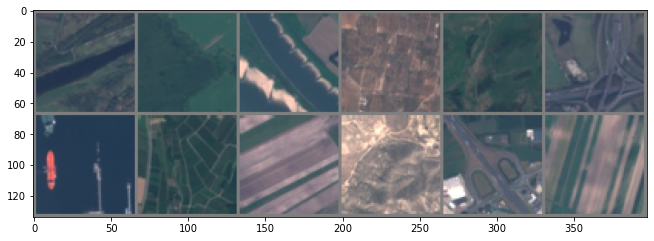

In [108]:
show_misclassified_images(misclassifiedLabels1)

In [109]:
print("Total Misclassified Images:", len(misclassifiedLabels1))

Total Misclassified Images: 1157


In [110]:
misclassified_images_per_labels1, label_prediction_accuracy1 = count_misclassified_images_per_label(confusion_matrix_report1)

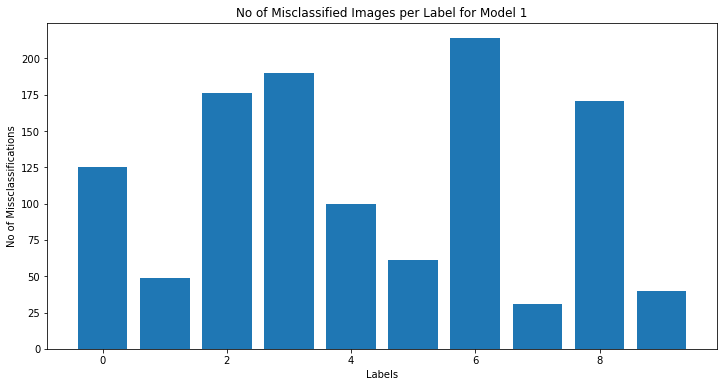

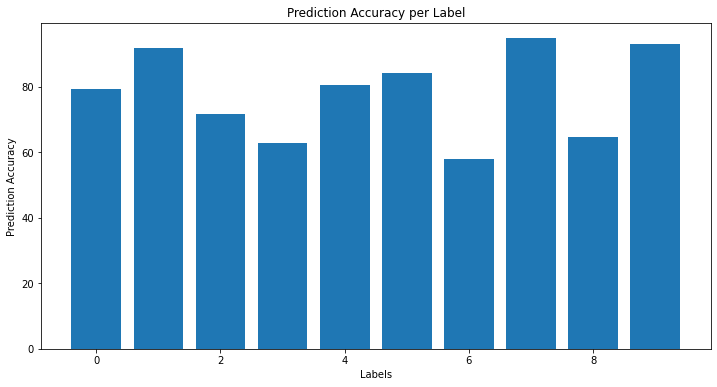

In [111]:
plot_misclassified_images_per_labels(misclassified_images_per_labels1, label_prediction_accuracy1, "No of Misclassified Images per Label for Model 1",
                                     "Prediction Accuracy per Label", labels)

In [113]:
low_accuracy_labels = [2, 3, 6, 8]

In [114]:
top_3_mislabeled1 = top_misclassified_predicted_labels(confusion_matrix_report1, low_accuracy_labels)

In [115]:
list_top_3_mislabeled_count(low_accuracy_labels, top_3_mislabeled1, confusion_matrix_report1)

For label 2, HerbaceousVegetation, top three misclassified labels are:
---> Mislabeled: 6 PermanentCrop
Count: 64
---> Mislabeled: 8 River
Count: 26
---> Mislabeled: 5 Pasture
Count: 24

For label 3, Highway, top three misclassified labels are:
---> Mislabeled: 8 River
Count: 69
---> Mislabeled: 6 PermanentCrop
Count: 34
---> Mislabeled: 2 HerbaceousVegetation
Count: 23

For label 6, PermanentCrop, top three misclassified labels are:
---> Mislabeled: 2 HerbaceousVegetation
Count: 74
---> Mislabeled: 3 Highway
Count: 52
---> Mislabeled: 5 Pasture
Count: 37

For label 8, River, top three misclassified labels are:
---> Mislabeled: 3 Highway
Count: 75
---> Mislabeled: 5 Pasture
Count: 33
---> Mislabeled: 0 AnnualCrop
Count: 27



/tmp/ipykernel_114/1613327927.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(Images[i]).cpu().reshape(1, 3, 64, 64)
/tmp/ipykernel_114/1613327927.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(misclassifiedLabel['image']).cpu().reshape(1, 3, 64, 64)


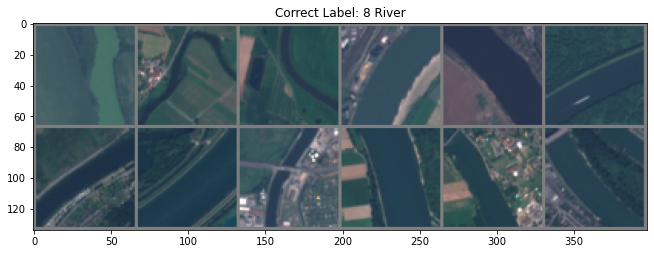

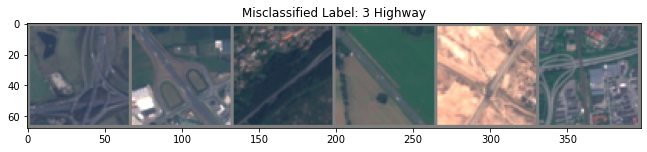

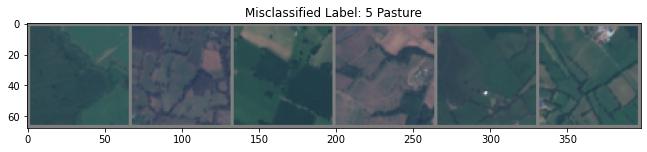

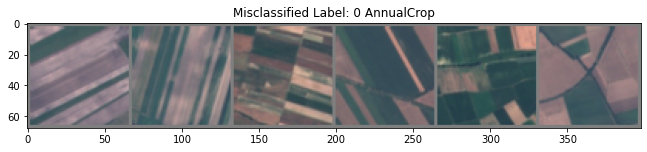

In [116]:
show_misclassified_images_per_labels(8, top_3_mislabeled1, misclassifiedLabels1)

/tmp/ipykernel_114/1613327927.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(Images[i]).cpu().reshape(1, 3, 64, 64)
/tmp/ipykernel_114/1613327927.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(misclassifiedLabel['image']).cpu().reshape(1, 3, 64, 64)


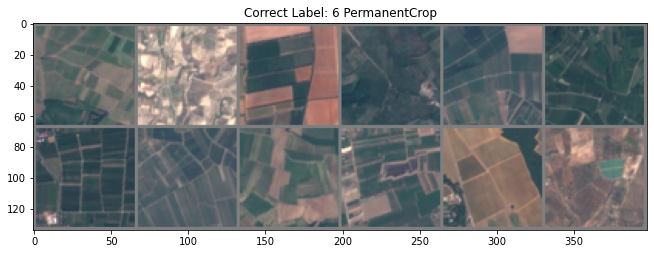

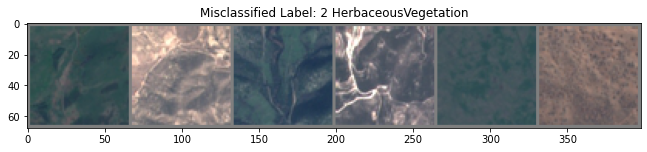

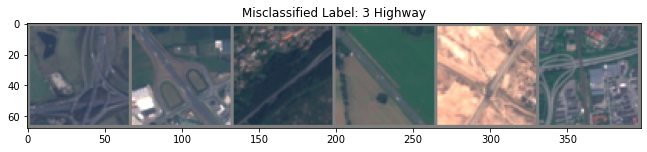

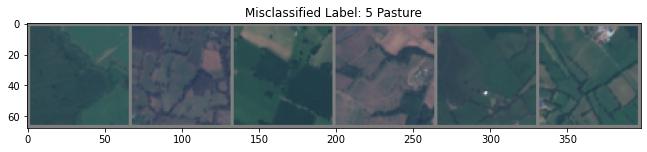

In [119]:
show_misclassified_images_per_labels(6, top_3_mislabeled1, misclassifiedLabels1)

/tmp/ipykernel_114/1613327927.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(Images[i]).cpu().reshape(1, 3, 64, 64)
/tmp/ipykernel_114/1613327927.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(misclassifiedLabel['image']).cpu().reshape(1, 3, 64, 64)


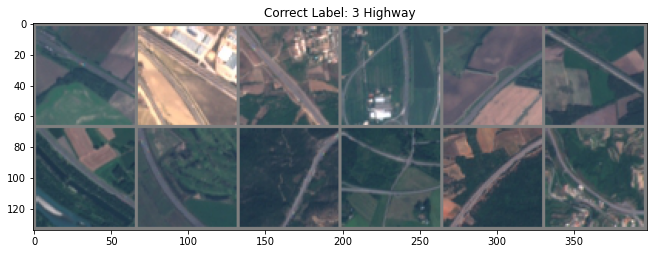

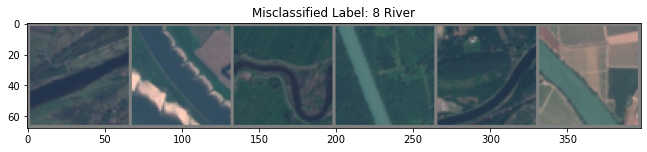

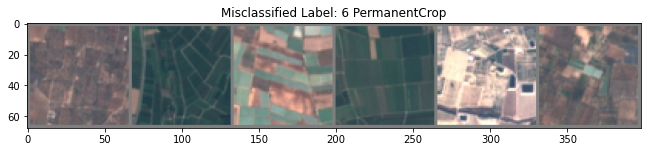

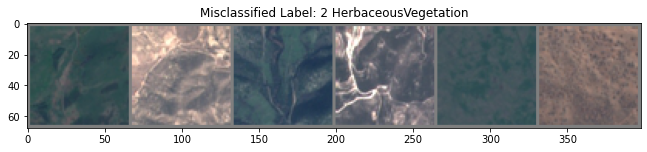

In [120]:
show_misclassified_images_per_labels(3, top_3_mislabeled1, misclassifiedLabels1)

/tmp/ipykernel_114/1613327927.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(Images[i]).cpu().reshape(1, 3, 64, 64)
/tmp/ipykernel_114/1613327927.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(misclassifiedLabel['image']).cpu().reshape(1, 3, 64, 64)


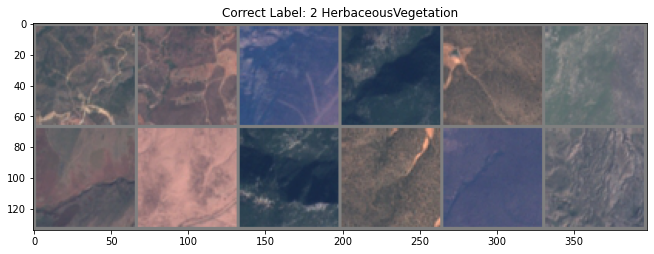

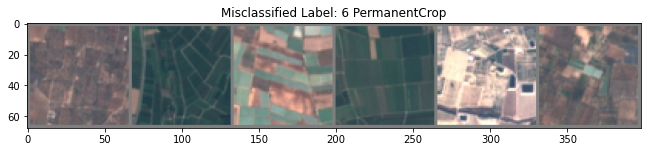

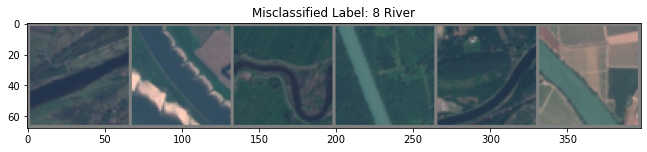

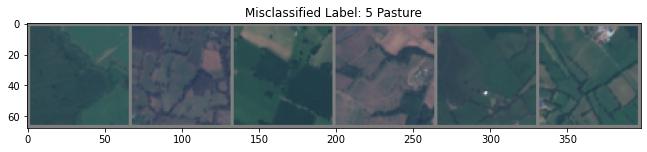

In [121]:
show_misclassified_images_per_labels(2, top_3_mislabeled1, misclassifiedLabels1)

## Model 2

/tmp/ipykernel_114/1957724292.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  miss = torch.tensor(misclassifiedLabels[i]['correctLabel']).cpu().reshape(1)
/tmp/ipykernel_114/1957724292.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correctLabel = torch.tensor(misclassifiedLabels[i]['predicted']).cpu().reshape(1)
/tmp/ipykernel_114/1957724292.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(misclassifiedLabels[i]['image']).cpu().reshape(1, 3, 64, 64)


Correct Labels:   tensor([5., 6., 6., 6., 6., 4., 6., 6., 6., 7., 6., 2.])
Predicted Labels: tensor([6., 2., 0., 2., 2., 7., 2., 2., 0., 4., 2., 6.])

Correct Label: 5.0 --> Pasture
Predicted Label: 6.0 --> PermanentCrop

Correct Label: 6.0 --> PermanentCrop
Predicted Label: 2.0 --> HerbaceousVegetation

Correct Label: 6.0 --> PermanentCrop
Predicted Label: 0.0 --> AnnualCrop

Correct Label: 6.0 --> PermanentCrop
Predicted Label: 2.0 --> HerbaceousVegetation

Correct Label: 6.0 --> PermanentCrop
Predicted Label: 2.0 --> HerbaceousVegetation

Correct Label: 4.0 --> Industrial
Predicted Label: 7.0 --> Residential

Correct Label: 6.0 --> PermanentCrop
Predicted Label: 2.0 --> HerbaceousVegetation

Correct Label: 6.0 --> PermanentCrop
Predicted Label: 2.0 --> HerbaceousVegetation

Correct Label: 6.0 --> PermanentCrop
Predicted Label: 0.0 --> AnnualCrop

Correct Label: 7.0 --> Residential
Predicted Label: 4.0 --> Industrial

Correct Label: 6.0 --> PermanentCrop
Predicted Label: 2.0 --> Herb

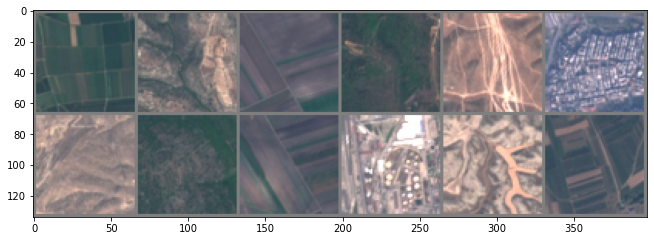

In [122]:
show_misclassified_images(misclassifiedLabels2)

In [123]:
print("Total Misclassified Images:", len(misclassifiedLabels2))

Total Misclassified Images: 780


In [124]:
misclassified_images_per_labels2, label_prediction_accuracy2 = count_misclassified_images_per_label(confusion_matrix_report2)

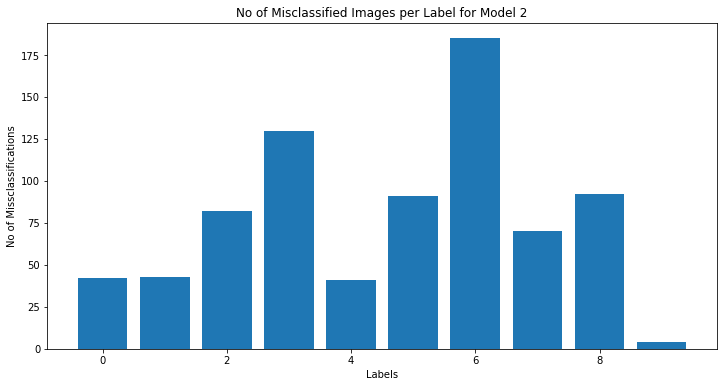

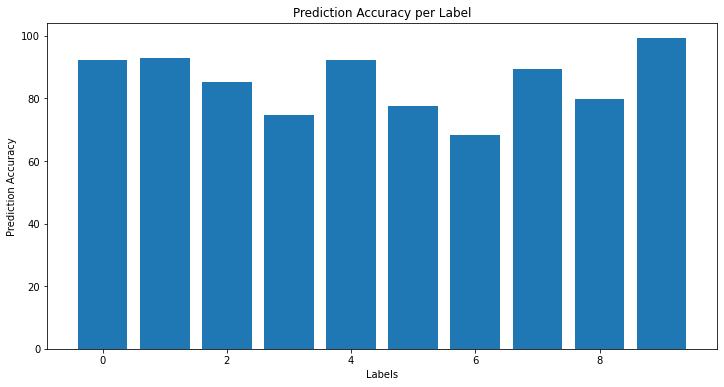

In [125]:
plot_misclassified_images_per_labels(misclassified_images_per_labels2, label_prediction_accuracy2, "No of Misclassified Images per Label for Model 2",
                                     "Prediction Accuracy per Label", labels)

In [126]:
low_accuracy_labels = [3, 5, 6, 8]

In [127]:
top_3_mislabeled2 = top_misclassified_predicted_labels(confusion_matrix_report2, low_accuracy_labels)

In [128]:
list_top_3_mislabeled_count(low_accuracy_labels, top_3_mislabeled2, confusion_matrix_report2)

For label 3, Highway, top three misclassified labels are:
---> Mislabeled: 8 River
Count: 52
---> Mislabeled: 6 PermanentCrop
Count: 30
---> Mislabeled: 2 HerbaceousVegetation
Count: 20

For label 5, Pasture, top three misclassified labels are:
---> Mislabeled: 8 River
Count: 22
---> Mislabeled: 1 Forest
Count: 18
---> Mislabeled: 0 AnnualCrop
Count: 16

For label 6, PermanentCrop, top three misclassified labels are:
---> Mislabeled: 2 HerbaceousVegetation
Count: 60
---> Mislabeled: 0 AnnualCrop
Count: 48
---> Mislabeled: 3 Highway
Count: 36

For label 8, River, top three misclassified labels are:
---> Mislabeled: 3 Highway
Count: 32
---> Mislabeled: 0 AnnualCrop
Count: 18
---> Mislabeled: 5 Pasture
Count: 15



/tmp/ipykernel_114/1613327927.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(Images[i]).cpu().reshape(1, 3, 64, 64)
/tmp/ipykernel_114/1613327927.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(misclassifiedLabel['image']).cpu().reshape(1, 3, 64, 64)


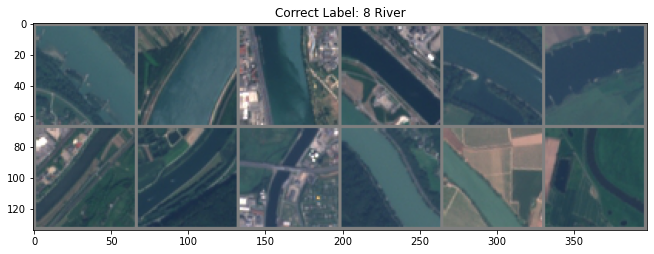

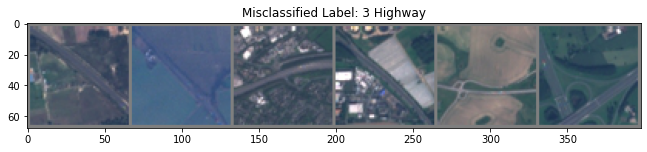

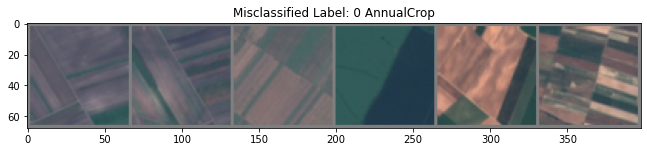

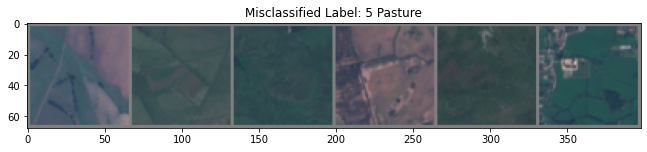

In [131]:
show_misclassified_images_per_labels(8, top_3_mislabeled2, misclassifiedLabels2)

/tmp/ipykernel_114/1613327927.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(Images[i]).cpu().reshape(1, 3, 64, 64)
/tmp/ipykernel_114/1613327927.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(misclassifiedLabel['image']).cpu().reshape(1, 3, 64, 64)


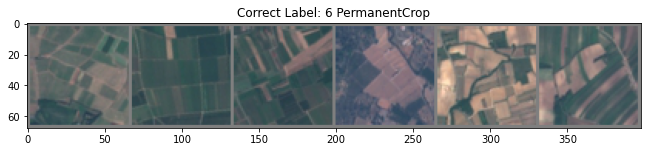

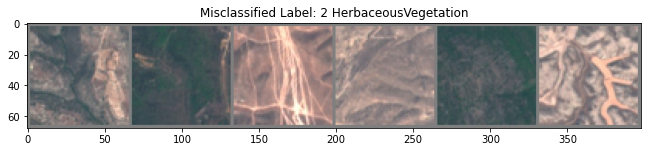

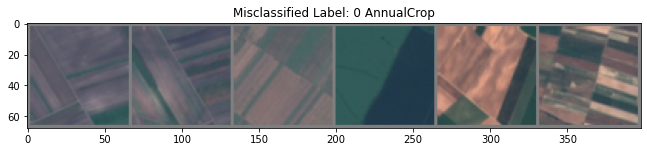

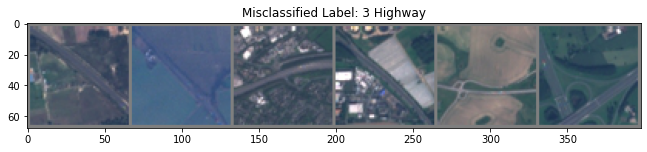

In [134]:
show_misclassified_images_per_labels(6, top_3_mislabeled2, misclassifiedLabels2)

/tmp/ipykernel_114/1613327927.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(Images[i]).cpu().reshape(1, 3, 64, 64)
/tmp/ipykernel_114/1613327927.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(misclassifiedLabel['image']).cpu().reshape(1, 3, 64, 64)


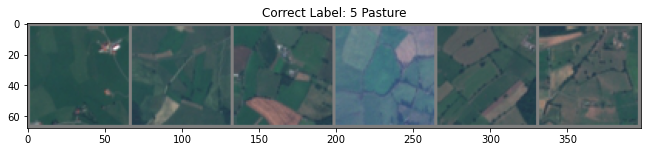

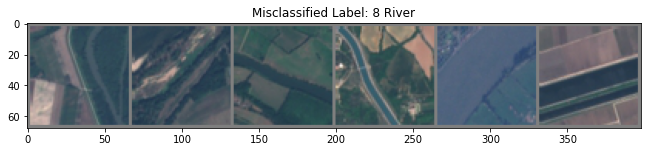

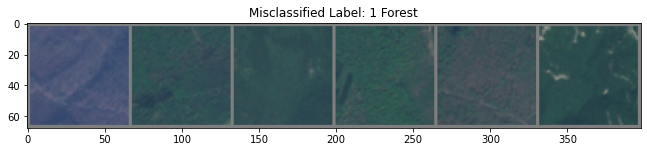

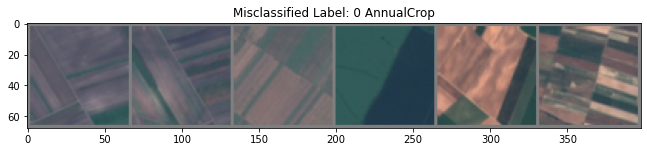

In [135]:
show_misclassified_images_per_labels(5, top_3_mislabeled2, misclassifiedLabels2)

/tmp/ipykernel_114/1613327927.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(Images[i]).cpu().reshape(1, 3, 64, 64)
/tmp/ipykernel_114/1613327927.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(misclassifiedLabel['image']).cpu().reshape(1, 3, 64, 64)


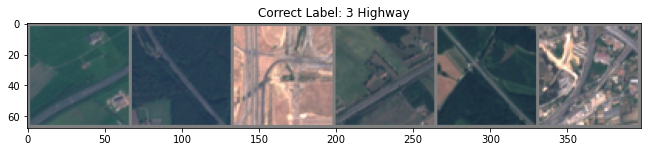

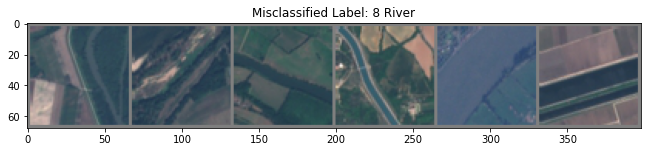

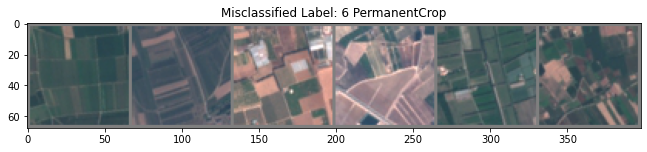

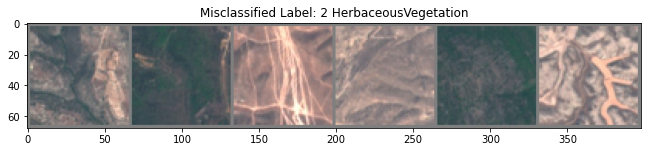

In [136]:
show_misclassified_images_per_labels(3, top_3_mislabeled2, misclassifiedLabels2)

## Model 3

/tmp/ipykernel_114/1957724292.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  miss = torch.tensor(misclassifiedLabels[i]['correctLabel']).cpu().reshape(1)
/tmp/ipykernel_114/1957724292.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correctLabel = torch.tensor(misclassifiedLabels[i]['predicted']).cpu().reshape(1)
/tmp/ipykernel_114/1957724292.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(misclassifiedLabels[i]['image']).cpu().reshape(1, 3, 64, 64)


Correct Labels:   tensor([7., 5., 9., 7., 8., 2., 6., 0., 2., 9., 1., 5.])
Predicted Labels: tensor([4., 6., 1., 4., 5., 6., 0., 8., 6., 0., 5., 1.])

Correct Label: 7.0 --> Residential
Predicted Label: 4.0 --> Industrial

Correct Label: 5.0 --> Pasture
Predicted Label: 6.0 --> PermanentCrop

Correct Label: 9.0 --> SeaLake
Predicted Label: 1.0 --> Forest

Correct Label: 7.0 --> Residential
Predicted Label: 4.0 --> Industrial

Correct Label: 8.0 --> River
Predicted Label: 5.0 --> Pasture

Correct Label: 2.0 --> HerbaceousVegetation
Predicted Label: 6.0 --> PermanentCrop

Correct Label: 6.0 --> PermanentCrop
Predicted Label: 0.0 --> AnnualCrop

Correct Label: 0.0 --> AnnualCrop
Predicted Label: 8.0 --> River

Correct Label: 2.0 --> HerbaceousVegetation
Predicted Label: 6.0 --> PermanentCrop

Correct Label: 9.0 --> SeaLake
Predicted Label: 0.0 --> AnnualCrop

Correct Label: 1.0 --> Forest
Predicted Label: 5.0 --> Pasture

Correct Label: 5.0 --> Pasture
Predicted Label: 1.0 --> Forest



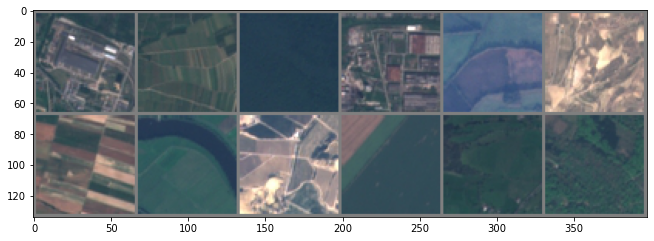

In [137]:
show_misclassified_images(misclassifiedLabels3)

In [138]:
print("Total Misclassified Images:", len(misclassifiedLabels3))

Total Misclassified Images: 634


In [139]:
misclassified_images_per_labels3, label_prediction_accuracy3 = count_misclassified_images_per_label(confusion_matrix_report3)

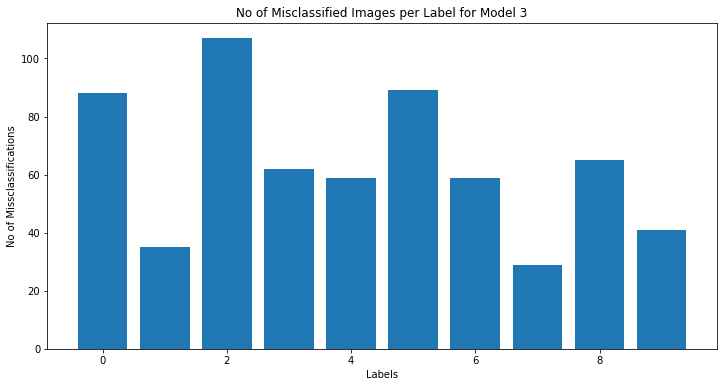

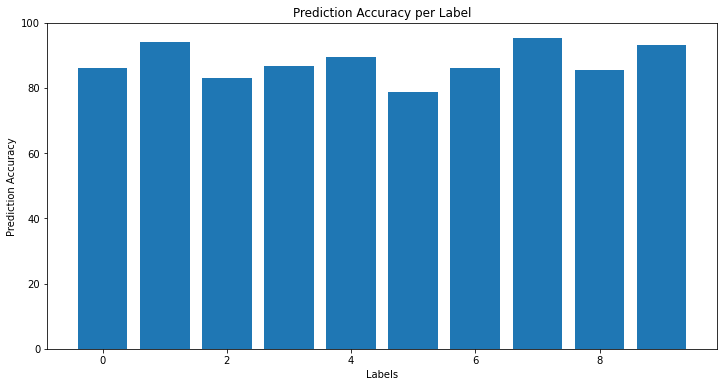

In [140]:
plot_misclassified_images_per_labels(misclassified_images_per_labels3, label_prediction_accuracy3, "No of Misclassified Images per Label for Model 3",
                                     "Prediction Accuracy per Label", labels)

In [141]:
low_accuracy_labels = [0, 2, 5, 8]

In [142]:
top_3_mislabeled3 = top_misclassified_predicted_labels(confusion_matrix_report3, low_accuracy_labels)

In [143]:
list_top_3_mislabeled_count(low_accuracy_labels, top_3_mislabeled3, confusion_matrix_report3)

For label 0, AnnualCrop, top three misclassified labels are:
---> Mislabeled: 6 PermanentCrop
Count: 29
---> Mislabeled: 8 River
Count: 27
---> Mislabeled: 5 Pasture
Count: 17

For label 2, HerbaceousVegetation, top three misclassified labels are:
---> Mislabeled: 6 PermanentCrop
Count: 66
---> Mislabeled: 3 Highway
Count: 16
---> Mislabeled: 0 AnnualCrop
Count: 8

For label 5, Pasture, top three misclassified labels are:
---> Mislabeled: 2 HerbaceousVegetation
Count: 22
---> Mislabeled: 6 PermanentCrop
Count: 21
---> Mislabeled: 8 River
Count: 16

For label 8, River, top three misclassified labels are:
---> Mislabeled: 3 Highway
Count: 25
---> Mislabeled: 2 HerbaceousVegetation
Count: 17
---> Mislabeled: 5 Pasture
Count: 9



/tmp/ipykernel_114/1613327927.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(Images[i]).cpu().reshape(1, 3, 64, 64)
/tmp/ipykernel_114/1613327927.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(misclassifiedLabel['image']).cpu().reshape(1, 3, 64, 64)


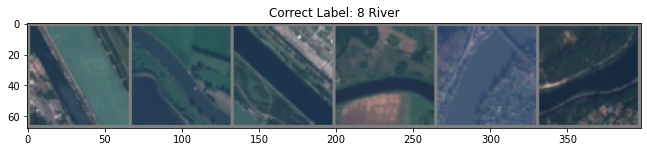

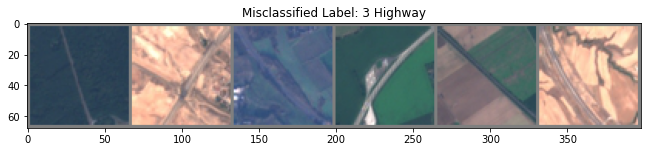

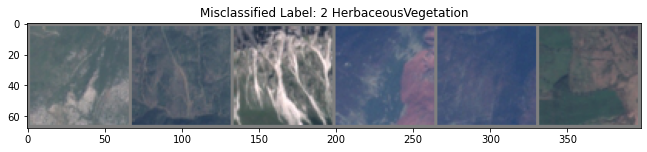

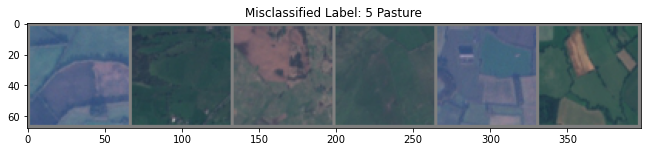

In [144]:
show_misclassified_images_per_labels(8, top_3_mislabeled3, misclassifiedLabels3)

/tmp/ipykernel_114/1613327927.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(Images[i]).cpu().reshape(1, 3, 64, 64)
/tmp/ipykernel_114/1613327927.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(misclassifiedLabel['image']).cpu().reshape(1, 3, 64, 64)


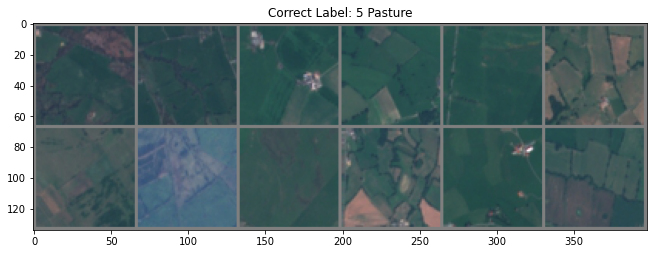

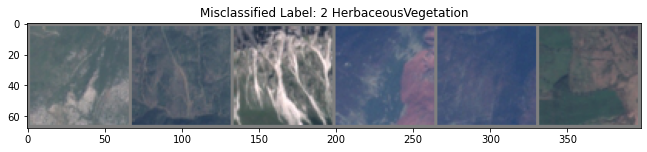

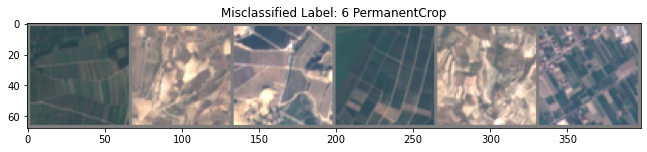

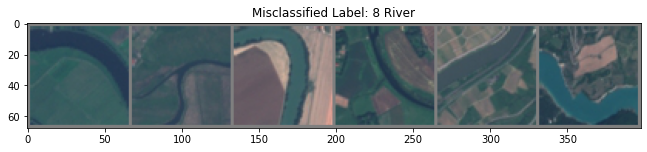

In [145]:
show_misclassified_images_per_labels(5, top_3_mislabeled3, misclassifiedLabels3)

/tmp/ipykernel_114/1613327927.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(Images[i]).cpu().reshape(1, 3, 64, 64)
/tmp/ipykernel_114/1613327927.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(misclassifiedLabel['image']).cpu().reshape(1, 3, 64, 64)


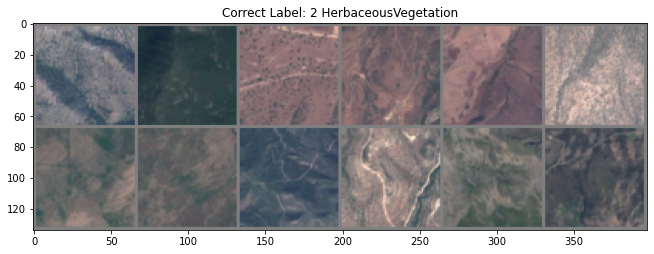

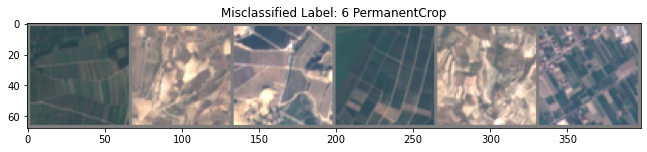

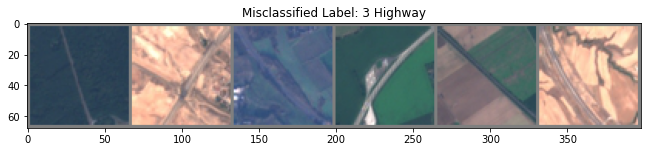

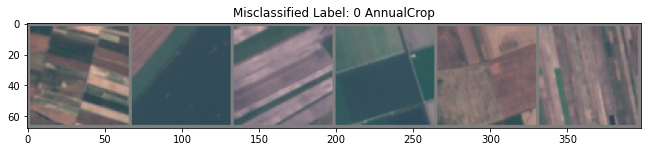

In [148]:
show_misclassified_images_per_labels(2, top_3_mislabeled3, misclassifiedLabels3)

/tmp/ipykernel_114/1613327927.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(Images[i]).cpu().reshape(1, 3, 64, 64)
/tmp/ipykernel_114/1613327927.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(misclassifiedLabel['image']).cpu().reshape(1, 3, 64, 64)


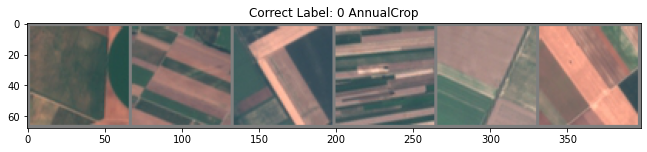

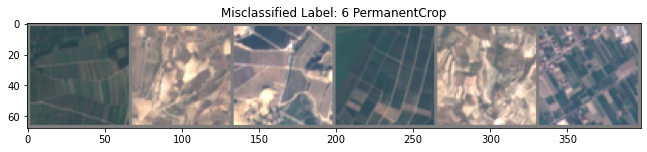

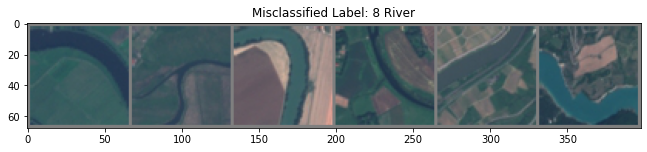

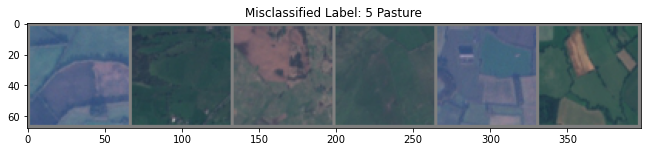

In [149]:
show_misclassified_images_per_labels(0, top_3_mislabeled3, misclassifiedLabels3)